In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import string
import regex as re
from nltk.corpus import stopwords
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


import emoji
from better_profanity import profanity


In [2]:
redits = pd.read_csv('./Data/scraped_clean_redits.csv')

In [3]:
redits.head()

,Title,Time,Comments,Subreddit
0,NaN,NaN,NaN,NaN
1,A random guy sends his vocals to deadmau5 - ge...,5 hours,526,r/Damnthatsinteresting
2,What is the craziest thing that's ever happene...,14 hours,7.1k,r/AskReddit
3,Woman is reunited with her dog that was missin...,6 hours,186,r/MadeMeSmile
4,[OC] saw this guy stealing a mirror in a parki...,6 hours,1.3k,r/pics


In [4]:
redits.columns = ['title', 'timestamp', 'comments', 'subreddit']


In [5]:
redits.dropna(inplace=True)

In [6]:
len(redits)

10160

## Converting the Time column isnto timestamp:

In [7]:
def convert_to_datetime(input):

    now = datetime.datetime.now()
    if 'minute' in input:
        number_of_minutes = int(input.split(' ')[0])                    
        time_posted = now - datetime.timedelta(minutes=number_of_minutes) 
        return time_posted
    
    elif 'hour' in input:
        number_of_hours = int(input.split(' ')[0])
        return now - datetime.timedelta(hours = number_of_hours)
    
    elif 'day' in input:
        number_of_days = int(input.split(' ')[0])
        return now - datetime.timedelta(days = number_of_days)
    
    elif 'month' in input:
        number_of_days = int(input.split(' ')[0])*30
        return now - datetime.timedelta(days=number_of_days)
    
    elif 'year' in input:
        number_of_days = int(input.split(' ')[0])*365
        return now - datetime.timedelta(days=number_of_days)
    
    elif 'just now' in input:
        return now - datetime.timedelta(hours= 15)
    
    else:
        return input

In [8]:
redits['timestamp'] = redits['timestamp'].apply(convert_to_datetime)

In [9]:
redits['timestamp'].head()

1   2022-09-06 18:30:02.440139
2   2022-09-06 09:30:02.440153
3   2022-09-06 17:30:02.440157
4   2022-09-06 17:30:02.440159
5   2022-09-06 09:30:02.440161
Name: timestamp, dtype: datetime64[ns]

## Converting the number of comments into integers:

In [10]:
def number_converter(each):
    if type(each) == float:
        return each
    else:
        if len(each) >5:
            return float(each.strip()[:2])
        else:
            each = each.strip()[:5]
        try:
            if 'm' in each:
                return float(each.strip('m').strip())*1_000_000
            elif 'k' in each:
                return float(each.strip('k').strip())*1_000
            else:
                return float(each)
        except:
            return None

In [11]:
redits['comments'] = redits['comments'].apply(number_converter)

In [12]:
redits['comments'].isnull().sum()

0

In [13]:
redits['comments'].dtypes

dtype('float64')

In [14]:
redits.head()

,title,timestamp,comments,subreddit
1,A random guy sends his vocals to deadmau5 - ge...,2022-09-06 18:30:02.440139,526.0,r/Damnthatsinteresting
2,What is the craziest thing that's ever happene...,2022-09-06 09:30:02.440153,7100.0,r/AskReddit
3,Woman is reunited with her dog that was missin...,2022-09-06 17:30:02.440157,186.0,r/MadeMeSmile
4,[OC] saw this guy stealing a mirror in a parki...,2022-09-06 17:30:02.440159,1300.0,r/pics
5,WCGW riding recklessly on the inter-state?,2022-09-06 09:30:02.440161,3900.0,r/Whatcouldgowrong


In [15]:
redits['title_length'] = redits['title'].apply(len)

In [16]:
redits.head()

,title,timestamp,comments,subreddit,title_length
1,A random guy sends his vocals to deadmau5 - ge...,2022-09-06 18:30:02.440139,526.0,r/Damnthatsinteresting,102
2,What is the craziest thing that's ever happene...,2022-09-06 09:30:02.440153,7100.0,r/AskReddit,55
3,Woman is reunited with her dog that was missin...,2022-09-06 17:30:02.440157,186.0,r/MadeMeSmile,61
4,[OC] saw this guy stealing a mirror in a parki...,2022-09-06 17:30:02.440159,1300.0,r/pics,84
5,WCGW riding recklessly on the inter-state?,2022-09-06 09:30:02.440161,3900.0,r/Whatcouldgowrong,42


Text(0.5, 0, 'number of characters')

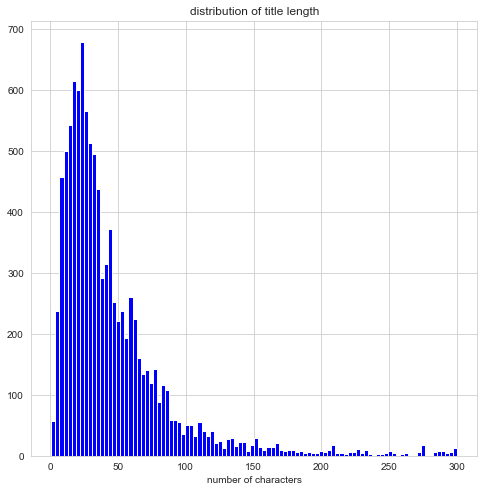

In [17]:
# Checking the distribution of title length:
plt.figure(figsize=(8,8))

plt.hist(redits['title_length'], bins=100, color='blue');
plt.title('distribution of title length')
plt.xlabel('number of characters')

In [18]:
redits['subreddit'].nunique()

1561

In [19]:
redits['subreddit'].value_counts().head(10)

r/memes               3786
r/Jokes                624
r/dadjokes             448
r/funny                181
r/shitposting          180
r/pics                 111
r/MadeMeSmile           92
r/me_irl                91
r/theworldnews          64
r/nextfuckinglevel      62
Name: subreddit, dtype: int64

# Distribution of top 6 subredits text:

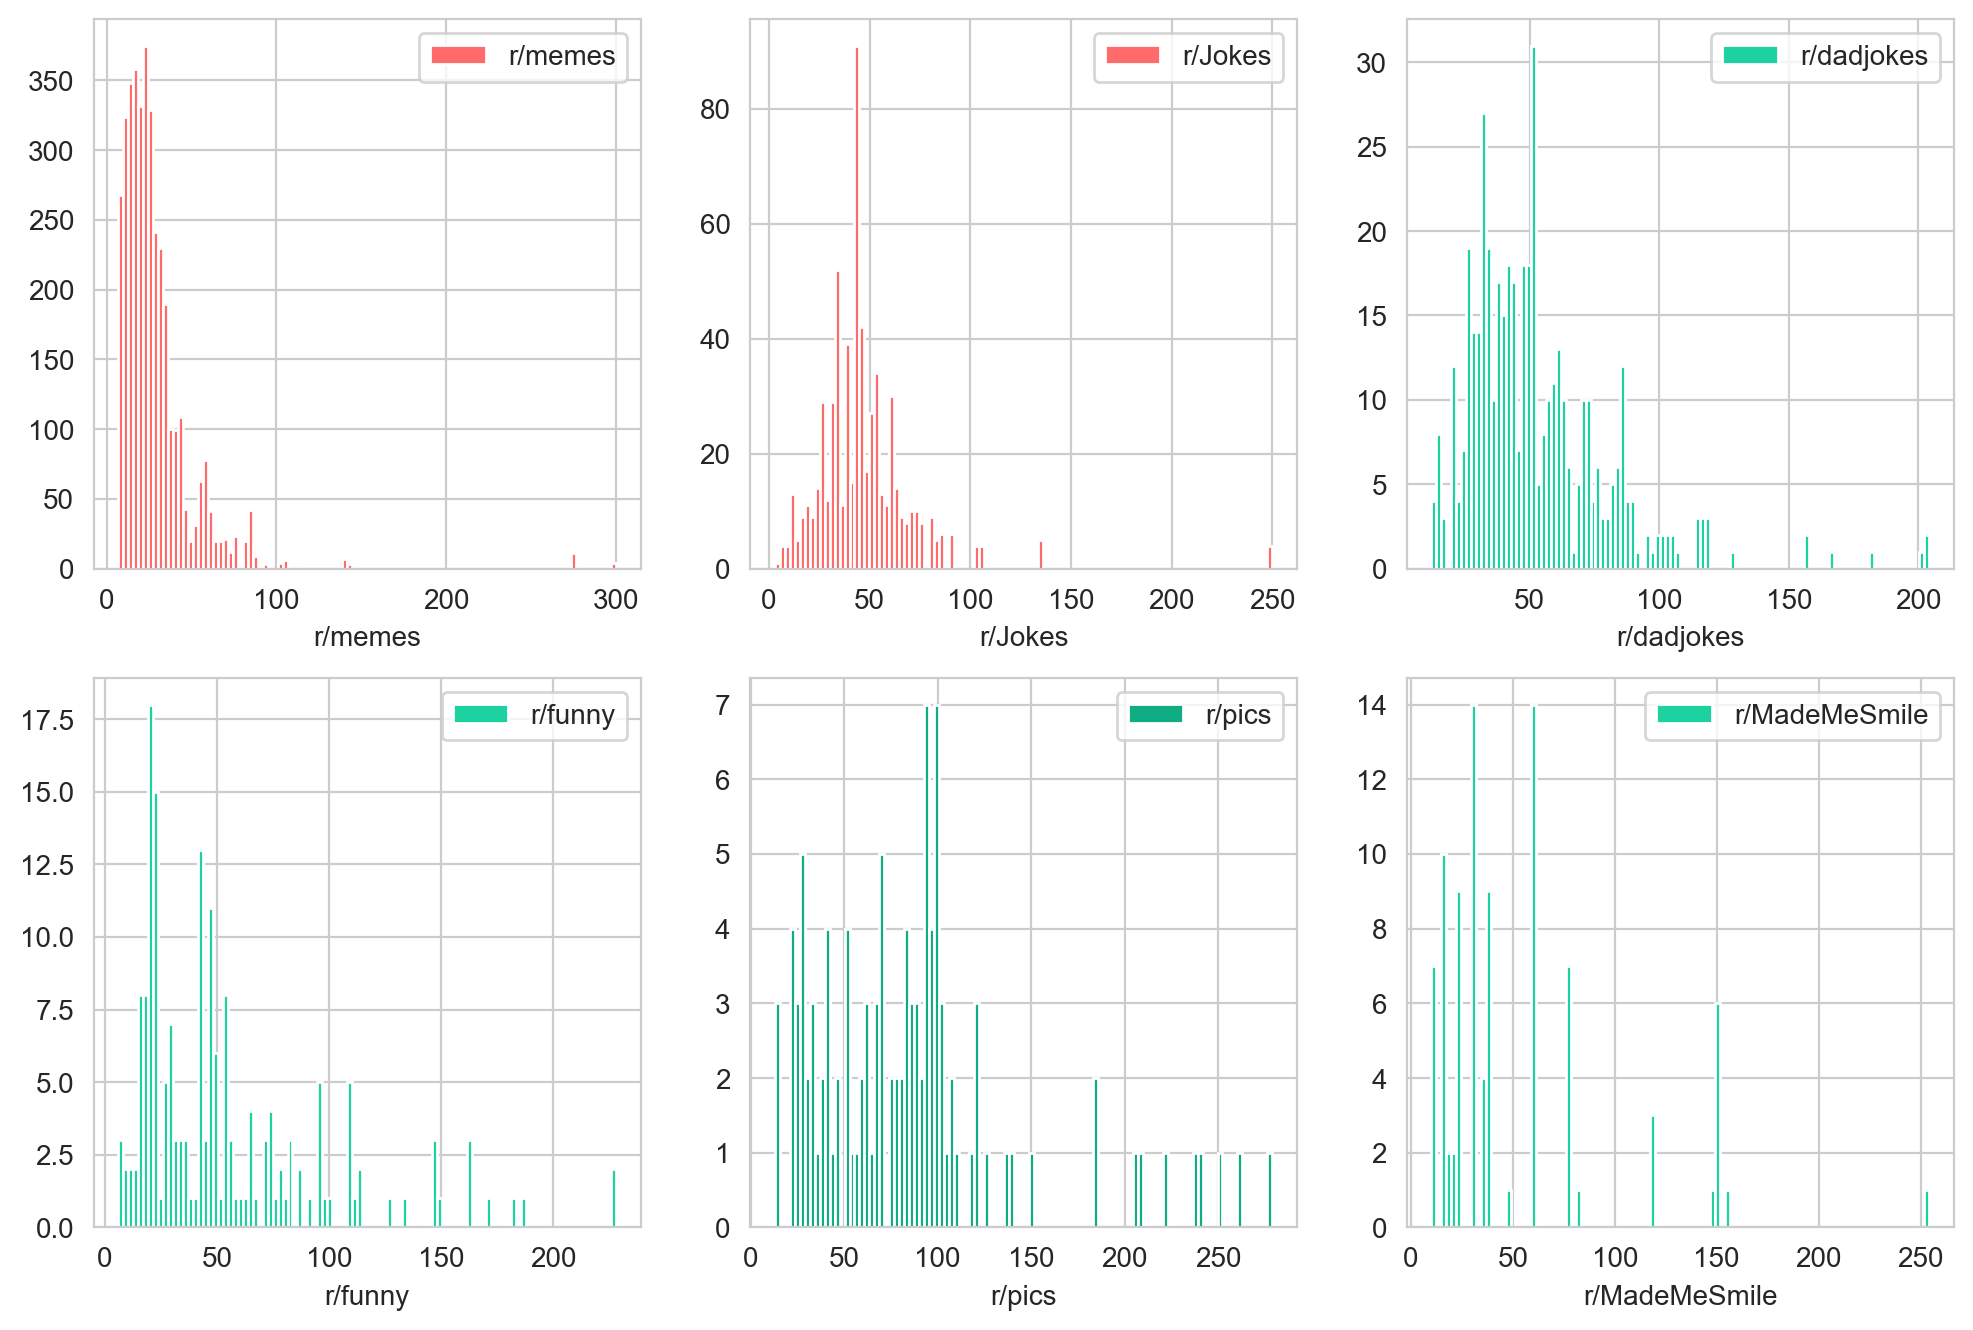

In [20]:
fig,ax = plt.subplots(2,3, figsize=(12,8), dpi=200)
ax[0,0].hist(redits[redits['subreddit']=='r/memes']['title_length'],bins=100, label = 'r/memes', color='#ff6b6b')
ax[0,0].set_xlabel('r/memes')
ax[0,0].legend()
ax[0,1].hist(redits[redits['subreddit']=='r/Jokes']['title_length'],bins=100, label = 'r/Jokes', color='#ff6b6b')
ax[0,1].set_xlabel('r/Jokes')
ax[0,1].legend()
ax[0,2].hist(redits[redits['subreddit']=='r/dadjokes']['title_length'],bins=100, label = 'r/dadjokes', color='#1dd1a1')
ax[0,2].set_xlabel('r/dadjokes')
ax[0,2].legend()
ax[1,0].hist(redits[redits['subreddit']=='r/funny']['title_length'],bins=100, label = 'r/funny', color='#1dd1a1')
ax[1,0].set_xlabel('r/funny')
ax[1,0].legend()
ax[1,1].hist(redits[redits['subreddit']=='r/pics']['title_length'],bins=100, label = 'r/pics', color='#10ac84')
ax[1,1].set_xlabel('r/pics')
ax[1,1].legend()
ax[1,2].hist(redits[redits['subreddit']=='r/MadeMeSmile']['title_length'],bins=100, label = 'r/MadeMeSmile', color='#1dd1a1')
ax[1,2].set_xlabel('r/MadeMeSmile')
ax[1,2].legend();


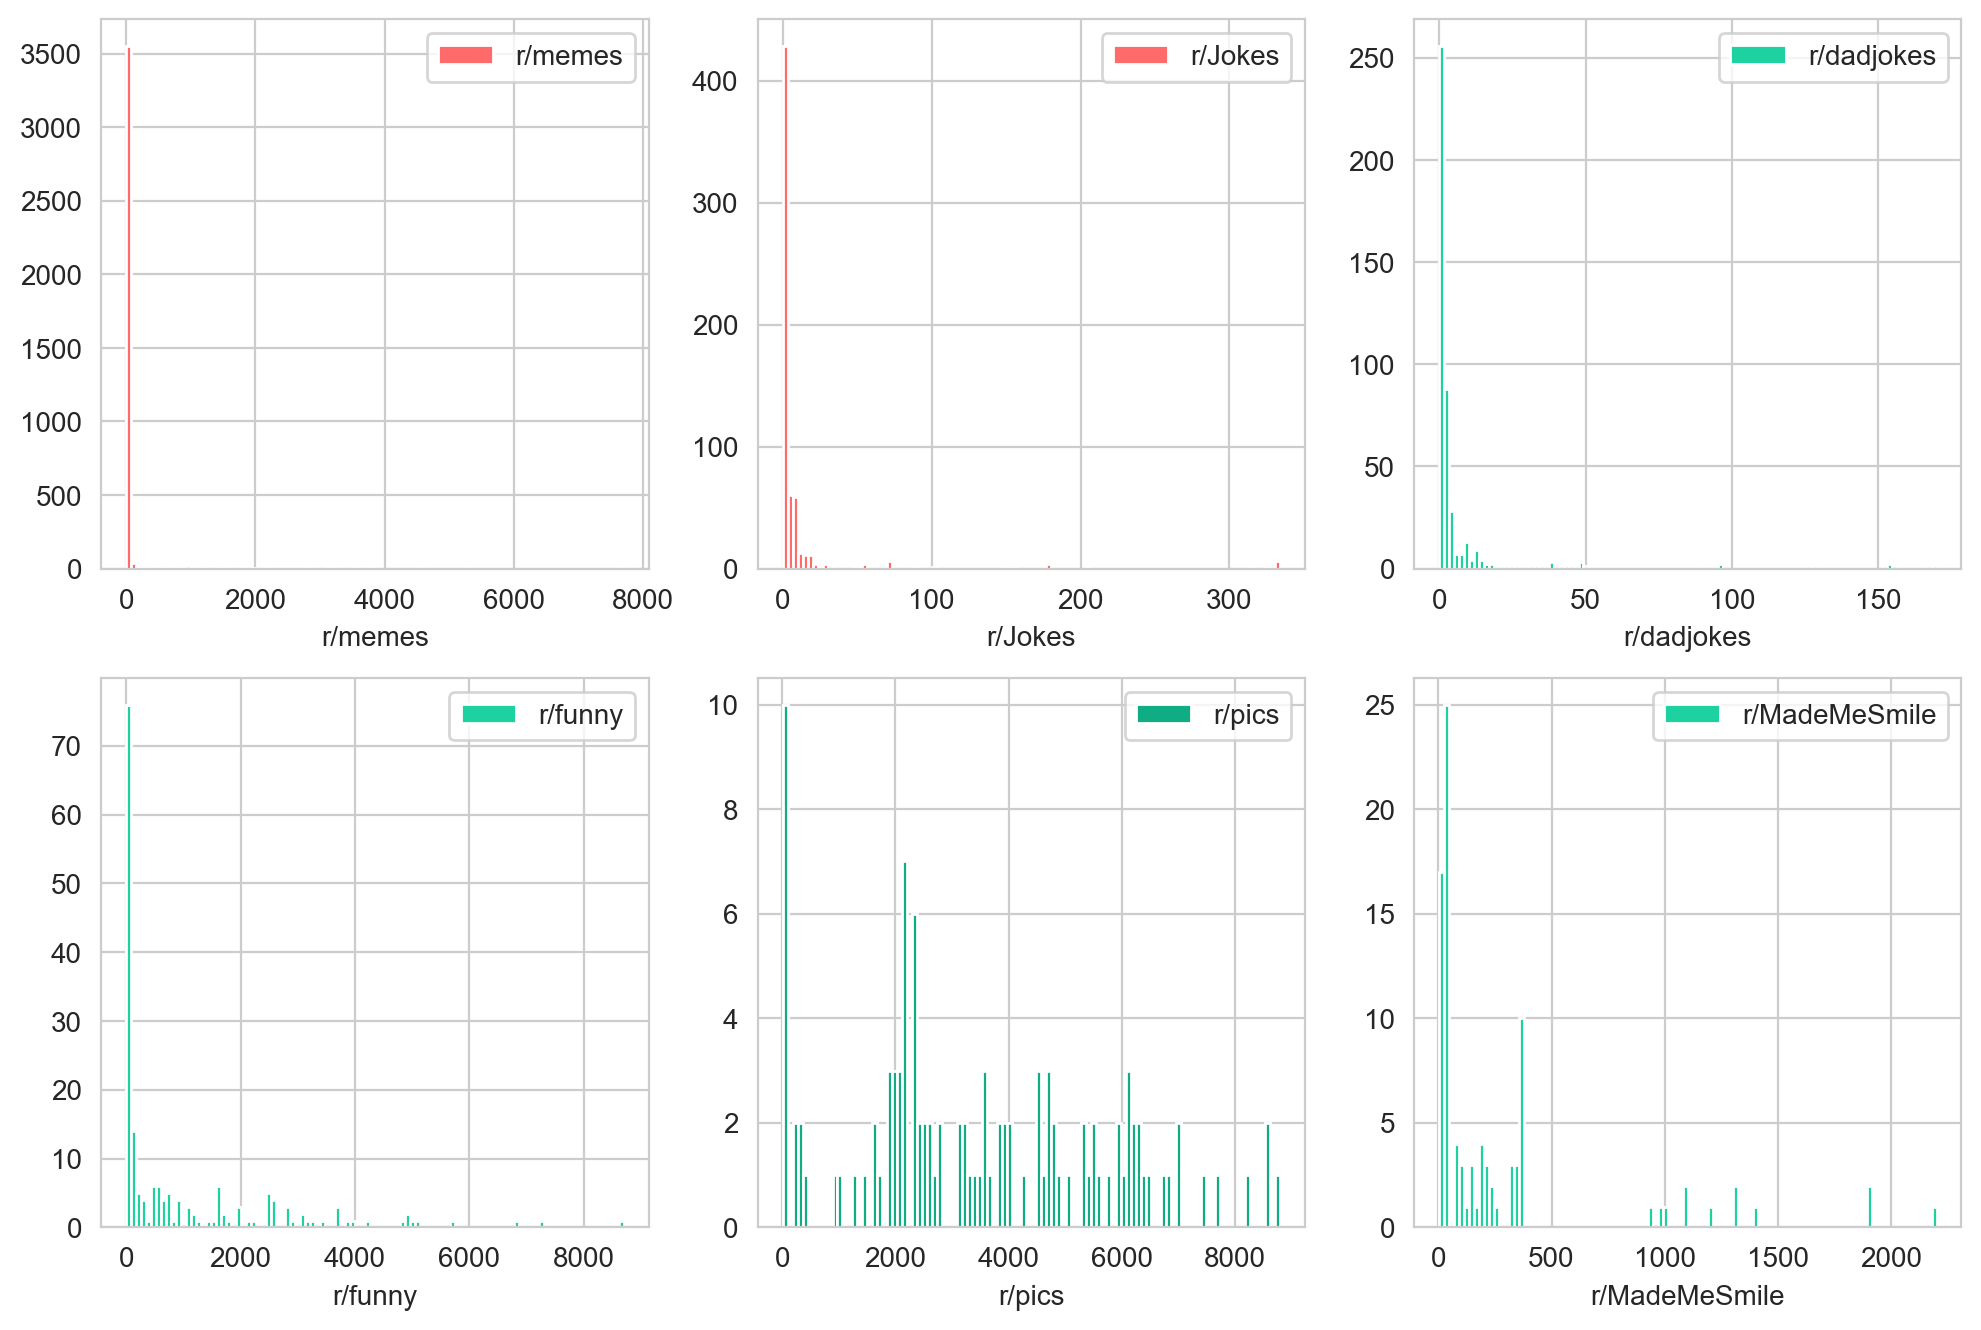

In [21]:
fig,ax = plt.subplots(2,3, figsize=(12,8), dpi=200)
ax[0,0].hist(redits[redits['subreddit']=='r/memes']['comments'],bins=100, label = 'r/memes', color='#ff6b6b')
ax[0,0].set_xlabel('r/memes')
ax[0,0].legend()
ax[0,1].hist(redits[redits['subreddit']=='r/Jokes']['comments'],bins=100, label = 'r/Jokes', color='#ff6b6b')
ax[0,1].set_xlabel('r/Jokes')
ax[0,1].legend()
ax[0,2].hist(redits[redits['subreddit']=='r/dadjokes']['comments'],bins=100, label = 'r/dadjokes', color='#1dd1a1')
ax[0,2].set_xlabel('r/dadjokes')
ax[0,2].legend()
ax[1,0].hist(redits[redits['subreddit']=='r/funny']['comments'],bins=100, label = 'r/funny', color='#1dd1a1')
ax[1,0].set_xlabel('r/funny')
ax[1,0].legend()
ax[1,1].hist(redits[redits['subreddit']=='r/pics']['comments'],bins=100, label = 'r/pics', color='#10ac84')
ax[1,1].set_xlabel('r/pics')
ax[1,1].legend()
ax[1,2].hist(redits[redits['subreddit']=='r/MadeMeSmile']['comments'],bins=100, label = 'r/MadeMeSmile', color='#1dd1a1')
ax[1,2].set_xlabel('r/MadeMeSmile')
ax[1,2].legend();


###  Checking the target column:

In [22]:
redits['comments'].median()

9.0

Text(0.5, 1.0, 'distribution of comments')

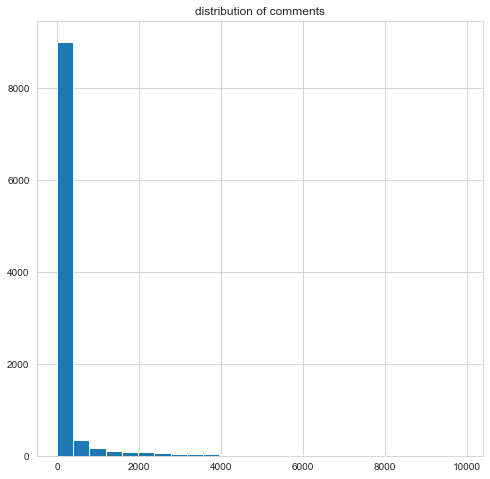

In [23]:
plt.figure(figsize=(8,8))

plt.hist(redits['comments'], bins = 25)
plt.title('distribution of comments')

# Establishing a baseline for a binary predictor:

In [24]:
redits['comments'].median()

9.0

Text(0.5, 1.0, 'baseline')

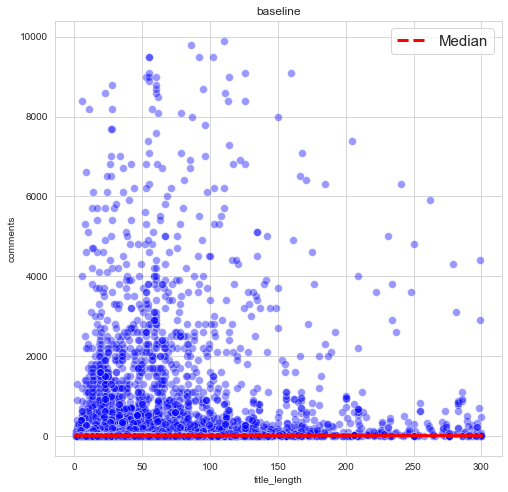

In [25]:
# Plotting the baseline:
plt.figure(figsize=(8,8))
y_mean = [np.median(redits['comments'])]*len(redits['title_length'])
sns.scatterplot(x =redits['title_length'],y = redits['comments'],color='blue',alpha=.4,s=60)
plt.plot(redits['title_length'],y_mean,label='Median', linestyle='--', color='red', linewidth=3)
plt.legend(fontsize=15);
plt.title('baseline')

## Exploring target distribution

In [26]:
# Adding high_enggement columns:
redits['high_engagement'] = redits['comments'].apply(lambda x: 1 if x > 9 else 0 )

Text(0.5, 1.0, 'target label balance')

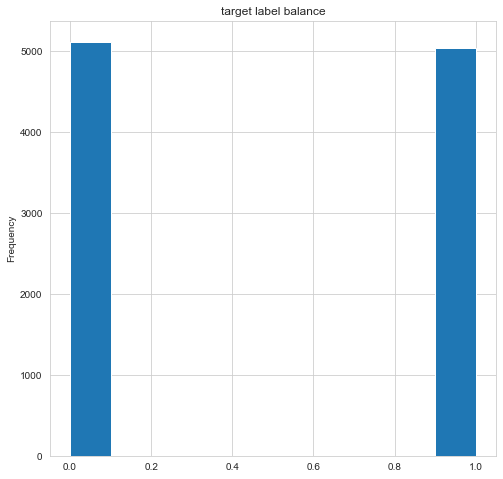

In [27]:
plt.figure(figsize=(8,8))
redits['high_engagement'].plot(kind='hist');
plt.title('target label balance')


In [28]:
redits['high_engagement'].value_counts(normalize=True)

0    0.503642
1    0.496358
Name: high_engagement, dtype: float64

- **My data is totally balanced, my baseline model will be predicting with about 50% accuracy**

In [29]:
redits.head()

,title,timestamp,comments,subreddit,title_length,high_engagement
1,A random guy sends his vocals to deadmau5 - ge...,2022-09-06 18:30:02.440139,526.0,r/Damnthatsinteresting,102,1
2,What is the craziest thing that's ever happene...,2022-09-06 09:30:02.440153,7100.0,r/AskReddit,55,1
3,Woman is reunited with her dog that was missin...,2022-09-06 17:30:02.440157,186.0,r/MadeMeSmile,61,1
4,[OC] saw this guy stealing a mirror in a parki...,2022-09-06 17:30:02.440159,1300.0,r/pics,84,1
5,WCGW riding recklessly on the inter-state?,2022-09-06 09:30:02.440161,3900.0,r/Whatcouldgowrong,42,1


In [30]:
# Adding day_of_post column:

redits['day_of_post'] = redits['timestamp'].apply(lambda ts : ts.date().day)

In [31]:
# Adding month_of_post column:

redits['month_of_post'] = redits['timestamp'].apply(lambda ts : ts.date().month)

In [32]:
# Adding hour_of_post column:

redits['hour_of_post'] = redits['timestamp'].apply(lambda ts : ts.time().hour)

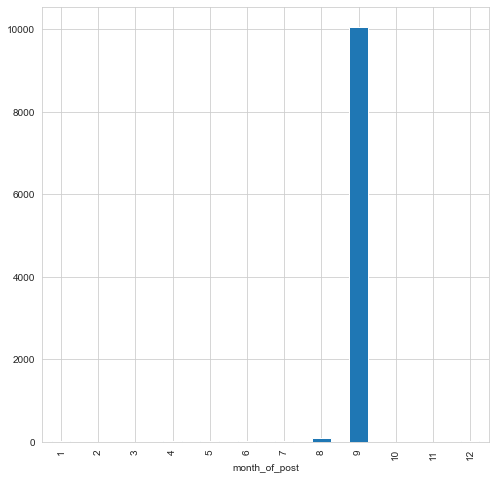

In [33]:
plt.figure(figsize=(8,8))
redits.groupby('month_of_post')['comments'].count().plot(kind='bar');


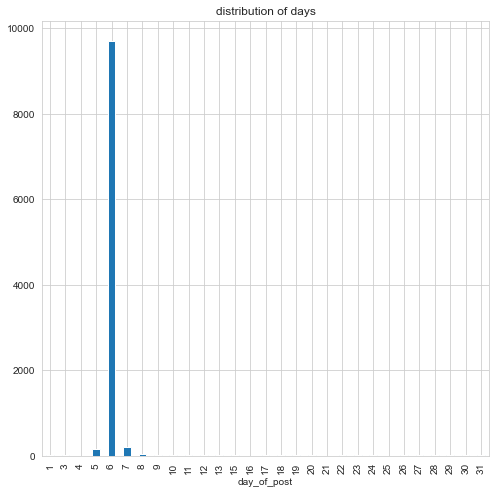

In [34]:
plt.figure(figsize=(8,8))
redits.groupby('day_of_post')['comments'].count().plot(kind='bar');
plt.title('distribution of days');


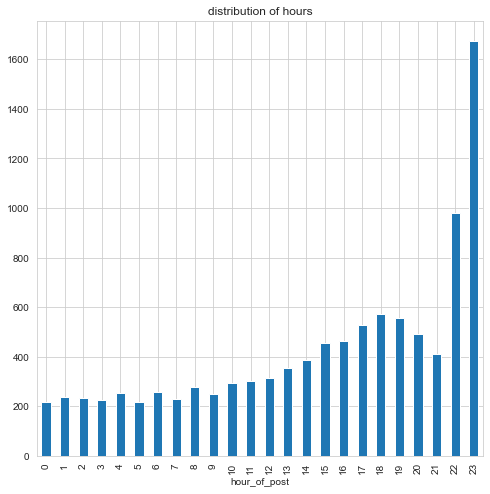

In [35]:
plt.figure(figsize=(8,8))
redits.groupby('hour_of_post')['comments'].count().plot(kind='bar');
plt.title('distribution of hours');


## Observation:
> - Data is highly deviated in the `day_of_post` and `month_of_post`  because it was all collected in Auguest 31st, so in this case, I don't think it will be a good idea to consider the month of the post as a good predictor of the engagement 
> - I can see that `hour_of_post` still can be a **good predictor** of the interaction since it's less deviatedand kind of **following a patern**

In [36]:
# Dropping the month_of_post column:

redits.drop(columns=['month_of_post', 'day_of_post'], inplace=True)

In [37]:
redits.head()

,title,timestamp,comments,subreddit,title_length,high_engagement,hour_of_post
1,A random guy sends his vocals to deadmau5 - ge...,2022-09-06 18:30:02.440139,526.0,r/Damnthatsinteresting,102,1,18
2,What is the craziest thing that's ever happene...,2022-09-06 09:30:02.440153,7100.0,r/AskReddit,55,1,9
3,Woman is reunited with her dog that was missin...,2022-09-06 17:30:02.440157,186.0,r/MadeMeSmile,61,1,17
4,[OC] saw this guy stealing a mirror in a parki...,2022-09-06 17:30:02.440159,1300.0,r/pics,84,1,17
5,WCGW riding recklessly on the inter-state?,2022-09-06 09:30:02.440161,3900.0,r/Whatcouldgowrong,42,1,9


## Text Cleaning:

In [38]:
# Removing all emojies
def remove_emoji(string):
    return emoji.replace_emoji(string, replace='').strip()


redits['title'] = redits['title'].apply(remove_emoji)

# converting all titles into lowercase:

redits['title'] = redits['title'].str.lower()

# removing profanity:

redits['title'] = redits['title'].apply(lambda x: profanity.censor(x))

# removing numbers from title:

redits['title'] = redits['title'].str.replace('\d+', '')

# Filter for strange characters:

redits['title'] = redits['title'].apply(lambda x: re.sub(r'\W+', ' ', x))

redits['title'] = redits['title'].apply(lambda x: re.sub(r"[^a-zA-Z0-9 ]", "", x))

/var/folders/b4/qnmj1swx0nx7h2b62nkjf05h0000gn/T/ipykernel_4193/2556191649.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  redits['title'] = redits['title'].str.replace('\d+', '')


## Splitting the data:

In [39]:
X = redits['title']
y = redits['high_engagement']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Using Pipeline:

### - Predicting with Random forest

In [41]:
# Using TFidfVectorizer:

pipe = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('rfc', RandomForestClassifier())
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9794713160854893, 0.838254593175853)

In [42]:
# Using CountVectorizer:


pipe = Pipeline([
    ('tfidf',CountVectorizer()),
    ('etc', RandomForestClassifier())
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9797525309336333, 0.8379265091863517)

### - Predicting with ExtraTrees Classifier

In [43]:
# Using CountVectorizer:

pipe = Pipeline([
    ('tfidf',CountVectorizer()),
    ('etc', ExtraTreesClassifier())
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9797525309336333, 0.8441601049868767)

In [44]:
# Using TfidfVectorizer:

pipe = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('etc', ExtraTreesClassifier())
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9794713160854893, 0.8480971128608924)

# Text Preprocessing:


### Tokenizing the titles:

In [45]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(doc)
    return [wnl.lemmatize(t) for t in tokens]

def stemmer_tokenizer(doc):
    ps = PorterStemmer()
    tokens = word_tokenize(doc)
    return [ps.stem(t) for t in tokens]

**Using `RandomForestClassifier` and `stemmer_tokenizer`**

In [46]:
# Using stemmer_tokenizer:

pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=stemmer_tokenizer)),
    ('tfidf',TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9803149606299213, 0.8484251968503937)

**Using `ExtraTreesClassifier` and `lemma_tokenizer`**

In [47]:
# Using lemma_tokenizer:

pipe = Pipeline([
    ('cv', CountVectorizer(tokenizer=lemma_tokenizer)),
    ('tfidf',TfidfTransformer()),
    ('rfc', ExtraTreesClassifier(n_estimators=1000))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9803149606299213, 0.8474409448818898)

**Using `AdaBoostClassifier`**

In [48]:
# Using lemma_tokenizer:

pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', ngram_range=(2,2))),
    # ('tfidf',TfidfTransformer()),
    ('abc', AdaBoostClassifier(n_estimators=2500))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8847019122609674, 0.7755905511811023)

### Using GridSearchCV

In [49]:
redits.head(2)

,title,timestamp,comments,subreddit,title_length,high_engagement,hour_of_post
1,a random guy sends his vocals to deadmau gets ...,2022-09-06 18:30:02.440139,526.0,r/Damnthatsinteresting,102,1,18
2,what is the craziest thing that s ever happene...,2022-09-06 09:30:02.440153,7100.0,r/AskReddit,55,1,9


In [50]:
X = redits.drop(columns=['timestamp','high_engagement', 'comments'])
y = redits['high_engagement']

### Using ColumnTransformer

In [51]:
numeric_features = ["title_length"]
numeric_transformer = Pipeline([("scaler", StandardScaler())])

categorical_features = ["subreddit", 'hour_of_post']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

text_featurs = "title"
# text_transformer = CountVectorizer(stop_words='english',analyzer=text_process, tokenizer= stemmer_tokenizer, ngram_range=(1,2)) 
text_transformer = Pipeline([
    ('cv', CountVectorizer( stop_words='english', tokenizer= lemma_tokenizer, ngram_range=(1,2))),
         ('tfidf',TfidfTransformer())#,
        # ('to_dense', DenseTransformer())

])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("txt", text_transformer, text_featurs)
    ]
)

**Using Pipeline with `AdaBoostClassifier`**

In [52]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", AdaBoostClassifier(n_estimators=4000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9881889763779528, 0.847769028871391)

**Using Pipeline with `RandomForestClassifier`**

In [53]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=300))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9962035995500562, 0.8868110236220472)

**Using Pipeline with `DecisionTreeClassifier`**

In [54]:

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9962035995500562, 0.885498687664042)

**Using Pipeline with `ExtraTreesClassifier`**

In [55]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", ExtraTreesClassifier(n_estimators=180))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


(0.9966254218222722, 0.8818897637795275)

In [56]:
pipe.named_steps['classifier']

ExtraTreesClassifier(n_estimators=180)

In [57]:
pipe['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['title_length']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['subreddit', 'hour_of_post']),
                                ('txt',
                                 Pipeline(steps=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english',
                                                                  tokenizer=<function lemma_tokenizer at 0x7fa583034670>)),
                                                 ('tfidf',
                                                  TfidfTransformer())]),
                                 'title')])

In [58]:
redits['high_engagement'].value_counts()

0    5117
1    5043
Name: high_engagement, dtype: int64

In [59]:
ft_imp_df = pd.DataFrame(pipe['classifier'].feature_importances_, 
             index=pipe['preprocessor'].get_feature_names_out(),
             columns=['ft_imps'])

### Most important subreddits correlated to interaction

<AxesSubplot:title={'center':'Most important subreddits correlated to high interaction'}, ylabel='subreddits'>

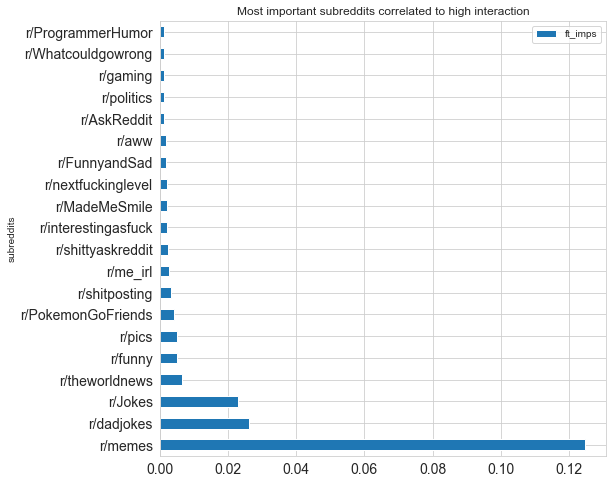

In [60]:

top_20_subs = ft_imp_df[ft_imp_df['ft_imps'] != 0].sort_values(by='ft_imps', ascending=False).filter(like='r/', axis=0).head(20)

top_20_subs.index = [each.split('subreddit_')[1] for each in top_20_subs.index]
top_20_subs.plot(kind='barh', title='Most important subreddits correlated to high interaction', figsize=(8,8), xlabel = 'subreddits' , fontsize=14)

In [61]:
# Most important subreddits
top_20_subs

,ft_imps
r/memes,0.124622
r/dadjokes,0.026242
r/Jokes,0.022962
r/theworldnews,0.006569
r/funny,0.005044
r/pics,0.005033
r/PokemonGoFriends,0.004238
r/shitposting,0.003220
r/me_irl,0.002607
r/shittyaskreddit,0.002397


## Interpretation:

- **These are the subreddits with high importance to high engagement posts:**
['r/memes', 'r/dadjokes', 'r/Jokes', 'r/theworldnews', 'r/funny',
       'r/pics', 'r/shitposting', 'r/PokemonGoFriends', 'r/MadeMeSmile',
       'r/me_irl', 'r/nextfuckinglevel', 'r/shittyaskreddit', 'r/FunnyandSad',
       'r/interestingasfuck', 'r/Whatcouldgowrong', 'r/ProgrammerHumor',
       'r/pyrocynical', 'r/aww', 'r/wallstreetbets', 'r/gaming']

### Most important hours correlated to interaction

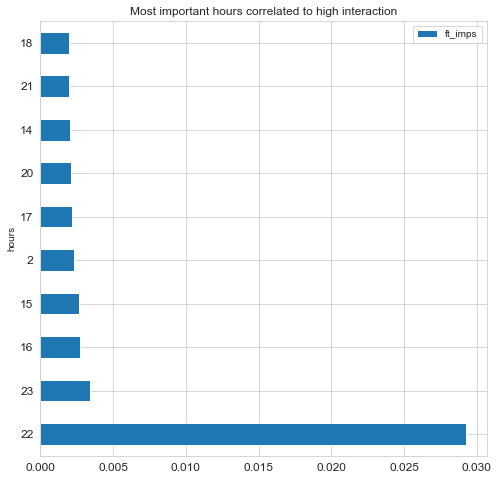

In [62]:

top_10_hours = ft_imp_df[ft_imp_df['ft_imps'] != 0].sort_values(by='ft_imps', ascending=False).filter(like='hour', axis=0).head(10)

top_10_hours.index = [each.split('hour_of_post_')[1] for each in top_10_hours.index]
top_10_hours.plot(kind='barh', title='Most important hours correlated to high interaction', figsize=(8,8), xlabel = 'hours', fontsize=12);


### Most important hours correlated to interaction

In [63]:
top_20_words = ft_imp_df[ft_imp_df['ft_imps'] != 0].sort_values(by='ft_imps', ascending=False).filter(like='txt', axis=0).head(20)
top_20_words.index = [each.split('__')[1] for each in top_20_words.index]
top_20_words

,ft_imps
mirror,0.002436
s,0.002198
meme,0.002031
pain,0.001734
meirl,0.001708
thank,0.001609
time,0.001560
vine,0.001502
know,0.001467
oh,0.001386


## Interpretation:

- **These are the words with high importance to high engagement posts:**
['s', 't', 'favorite', 'meme', 'just', 'time', 'wa', 'ha', 'know',
       'like', 'mirror', 'meirl', 'guy', 'thank', 'say', 'got', 'moment',
       'tell', 'm', 'oh']

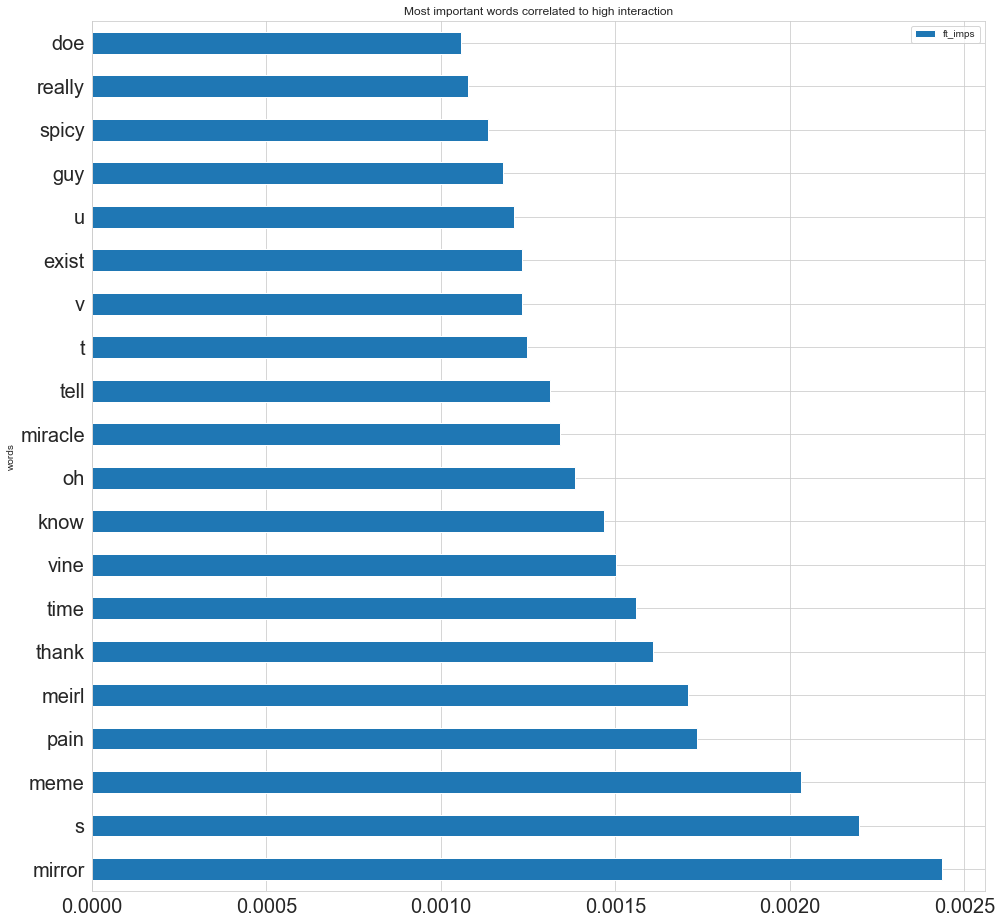

In [64]:
top_20_words.plot(kind='barh', title='Most important words correlated to high interaction', figsize=(16,16), xlabel = 'words', fontsize=20)
plt.savefig('best words.png', bbox_inches='tight')